Title: Time Series and EOF Analysis with Monthly ERA-5 Data for a 42-year Temperature and Precipitation Analysis in the Upper Colorado River Basin (UCRB)

Motivation: The climate in the UCRB now seems to be facing the possibility of aridification. It may one day go from a semi-arid environment to an arid environment. I want to do a basic analysis of the temperature and precipitation data to determine if aridification is influencing the greater UCRB area. 

Scientific question to be answered: Over the last 42 years, how has temperature and precipitation patterns changed the Upper Colorado River Basin (UCRB)? By utilizing ERA-5 data,  can a successful investigation be done on the possibility of aridification in the UCRB?

Datasets to be used: https://cloud.google.com/storage/docs/public-datasets/era5


Total_column_rain_water_surface_Mixed_intervals_Average

Surface_temperature_surface_Mixed_intervals_Average

potential ideas:

def should do a train test split to see patterns
EOF to quanitfy, see the dom spatial patterns of variability


### Import needed packages

In [1]:
# import needed packages

import xarray as xr
import pandas as pd
import geopandas as gpd 
import numpy as np 
import datetime as datetime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


### Set up dask client for large dataset

In [2]:
# import dask and start client

import dask
from dask.distributed import Client, progress
dask.config.set(temporary_directory='/tmp/snesbitt/dask-worker/')

In [3]:
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 19.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53258,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 19.86 GiB
Comm: tcp://127.0.0.1:53279,Total threads: 4
Dashboard: http://127.0.0.1:53280/status,Memory: 4.96 GiB
Nanny: tcp://127.0.0.1:53261,


### Load in shapefile for UCRB to use in visualizations

In [4]:
import geopandas as gpd
import os

# Folder path where the shapefile is located
shapefile_folder = r'C:\Users\Sophie\OneDrive\Git\ATMS523-Project-SF\UpperColoradoRi\Upper_Colorado_River_Basin_Boundary'

# Full path to the shapefile
upper_colorado_shapefile_path = os.path.join(shapefile_folder, 'Upper_Colorado_River_Basin_Boundary.shp')

# Load the shapefile using geopandas
upper_colorado_gdf = gpd.read_file(upper_colorado_shapefile_path)

print(upper_colorado_gdf.head())


   EXT_ID  EXT_TYP_ID                   NAME  \
0    9389         5.0  Upper Colorado Region   

                                            geometry  
0  POLYGON ((-106.65587 40.51559, -106.65376 40.5...  


In [5]:
# Get the total bounding box of the UCRB mask
bbox = upper_colorado_gdf.total_bounds

# Extract minimum and maximum coordinates
min_lon_b, min_lat_b, max_lon_b, max_lat_b = bbox

# Convert longitude to standard used on the era-5 ds
min_lon = min_lon_b + 360
max_lon = max_lon_b + 360

# Define min and max lat
min_lat = 35.55788422
max_lat = 43.45014572

In [6]:
# Check for reference
bbox

array([-112.32627869,   35.55788422, -105.62832642,   43.45014572])

In [7]:
# Retrieve ERA-5 Monthly Mean Dataset at NCAR 
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})



In [8]:
# Check dataset
ds

<xarray.Dataset>
Dimensions:                                                                                             (
                                                                                                         lat: 721,
                                                                                                         lon: 1440,
                                                                                                         time: 516,
                                                                                                         layer_between_two_depths_below_surface_layer: 1,
                                                                                                         layer_between_two_depths_below_surface_layer1: 1,
                                                                                                         ...
                                                                                                         layer_between_two_depths_below_surface_layer3: 1,
                                                                                                         time_bounds_1: 2,
                                                                                                         layer_between_two_depths_below_surface_layer_bounds_1: 2,
                                                                                                         layer_between_two_depths_below_surface_layer1_bounds_1: 2,
                                                                                                         layer_between_two_depths_below_surface_layer2_bounds_1: 2,
                                                                                                         layer_between_two_depths_below_surface_layer3_bounds_1: 2)
Coordinates:
  * lat                                                                                                 (lat) float32 ...
  * lon                                                                                                 (lon) float32 ...
  * time                                                                                                (time) datetime64[ns] ...
    reftime                                                                                             (time) datetime64[ns] dask.array<chunksize=(516,), meta=np.ndarray>
  * layer_between_two_depths_below_surface_layer                                                        (layer_between_two_depths_below_surface_layer) float32 ...
  * layer_between_two_depths_below_surface_layer1                                                       (layer_between_two_depths_below_surface_layer1) float32 ...
  * layer_between_two_depths_below_surface_layer2                                                       (layer_between_two_depths_below_surface_layer2) float32 ...
  * layer_between_two_depths_below_surface_layer3                                                       (layer_between_two_depths_below_surface_layer3) float32 ...
Dimensions without coordinates: time_bounds_1,
                                layer_between_two_depths_below_surface_layer_bounds_1,
                                layer_between_two_depths_below_surface_layer1_bounds_1,
                                layer_between_two_depths_below_surface_layer2_bounds_1,
                                layer_between_two_depths_below_surface_layer3_bounds_1
Data variables: (12/85)
    LatLon_Projection                                                                                   int32 ...
    time_bounds                                                                                         (time, time_bounds_1) datetime64[ns] dask.array<chunksize=(516, 2), meta=np.ndarray>
    layer_between_two_depths_below_surface_layer_bounds                                                 (layer_between_two_depths_below_surface_layer, layer_between_two_depths_below_surface_layer_bounds_1) float32 dask.array<chunksize=(1, 2)

Refine coordinate extent for most precise area of representation. This will involve creating an original subsetted UCRB dataset and creating a refined version of this dataset.

In [9]:
# Select the two needed variables
variables = ['Total_column_rain_water_surface_Mixed_intervals_Average',
        '2_metre_temperature_surface_Mixed_intervals_Average']

# Subset the ds using the UCRB mask coordinates, and then specifically subset with chosen variables
ds_ucrb = ds[variables].sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon))

In [10]:
ds_ucrb # success!This is our original, kept it in for reference

<xarray.Dataset>
Dimensions:                                                  (time: 516,
                                                              lat: 31, lon: 27)
Coordinates:
  * lat                                                      (lat) float32 43...
  * lon                                                      (lon) float32 24...
  * time                                                     (time) datetime64[ns] ...
    reftime                                                  (time) datetime64[ns] dask.array<chunksize=(516,), meta=np.ndarray>
Data variables:
    Total_column_rain_water_surface_Mixed_intervals_Average  (time, lat, lon) float32 dask.array<chunksize=(120, 31, 27), meta=np.ndarray>
    2_metre_temperature_surface_Mixed_intervals_Average      (time, lat, lon) float32 dask.array<chunksize=(120, 31, 27), meta=np.ndarray>
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [11]:
# This is after trial and error, which was not included individually for the sake of efficiency.
# As you can see, I have set refined min and max latitudes, longitudes

max_lat2 = 43.75
min_lat2 = 35.5
max_lon2 = 254.5
min_lon2 = 247.5

# Subset the ds using the UCRB mask coordinates, and then specifically subset with chosen variables
ds_ucrb_2 = ds[variables].sel(lat=slice(max_lat2, min_lat2), lon=slice(min_lon2, max_lon2))

# get it in netcdf format
#ds_ucrb_2.to_netcdf('raw_data_5.nc')

# Note: It took 5 tries for me to accurately represent the full extent of the UCRB boundary, i.e. tinkering with the lat and lon extent

In [12]:
raw_ds_5 = xr.open_dataset('raw_data_5.nc')
raw_ds_5

<xarray.Dataset>
Dimensions:                                                  (time: 516,
                                                              lat: 33, lon: 29)
Coordinates:
  * lat                                                      (lat) float32 43...
  * lon                                                      (lon) float32 24...
  * time                                                     (time) datetime64[ns] ...
    reftime                                                  (time) datetime64[ns] ...
Data variables:
    Total_column_rain_water_surface_Mixed_intervals_Average  (time, lat, lon) float32 ...
    2_metre_temperature_surface_Mixed_intervals_Average      (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

### Next step is to visualize the raw data as is 

In [13]:
# Total column rainwater, collapse over time dimension for 2D plotting
tcrw_avg_ds = raw_ds_5['Total_column_rain_water_surface_Mixed_intervals_Average'].mean(dim='time')

tcrw_avg_ds

<xarray.DataArray 'Total_column_rain_water_surface_Mixed_intervals_Average' (
                                                                             lat: 33,
                                                                             lon: 29)>
array([[0.00072247, 0.00075813, 0.00074733, 0.00072387, 0.00061281,
        0.00052042, 0.00043198, 0.00039953, 0.00035009, 0.00028246,
        0.00024473, 0.00027643, 0.00033057, 0.0003911 , 0.00043885,
        0.00051458, 0.0005665 , 0.00059985, 0.00064791, 0.00061375,
        0.00055829, 0.00048371, 0.00065366, 0.00075619, 0.0008182 ,
        0.00077005, 0.00080207, 0.0008504 , 0.00093625],
       [0.00079906, 0.00074655, 0.00073571, 0.00061425, 0.00060391,
        0.00051127, 0.00046116, 0.00037568, 0.00032636, 0.00032137,
        0.00024163, 0.00027361, 0.00026225, 0.00051018, 0.00055782,
        0.00069595, 0.0005405 , 0.00057378, 0.00062391, 0.00054862,
        0.0004931 , 0.00045363, 0.00055928, 0.00066211, 0.00064874,
        0.00065847, 0.00069112, 0.00077307, 0.00088144],
       [0.0008365 , 0.00076519, 0.0006603 , 0.00053659, 0.00053742,
        0.00051965, 0.0004737 , 0.00038491, 0.00040168, 0.00042903,
        0.00034964, 0.00025269, 0.00020347, 0.00041187, 0.00061343,
        0.00082169, 0.00066372, 0.0005772 , 0.00059893, 0.00053087,
        0.00050685, 0.00047498, 0.00056948, 0.00061001, 0.00059664,
        0.00061404, 0.00067126, 0.00075395, 0.00085141],
       [0.00077058, 0.00072636, 0.00065957, 0.00055365, 0.00052278,
        0.0004766 , 0.00042331, 0.00033324, 0.00034144, 0.00045651,
...
        0.00064625, 0.00063458, 0.00060834, 0.00059032, 0.00059228,
        0.00069235, 0.00076905, 0.00072399, 0.00088752],
       [0.00075401, 0.0007387 , 0.00063076, 0.00066736, 0.00065492,
        0.00063355, 0.00059238, 0.0005916 , 0.00056813, 0.00053678,
        0.00054144, 0.0005888 , 0.00057683, 0.00056324, 0.00062881,
        0.00061827, 0.00063972, 0.0006341 , 0.00063214, 0.00061435,
        0.00062292, 0.0006362 , 0.00061136, 0.00060846, 0.00071401,
        0.00081496, 0.00076763, 0.00098119, 0.00114478],
       [0.00067854, 0.00068075, 0.0006148 , 0.00068894, 0.00074279,
        0.00072499, 0.00064765, 0.00062319, 0.00060358, 0.00059584,
        0.00059813, 0.00061678, 0.00060237, 0.00059181, 0.00060631,
        0.00060647, 0.00063617, 0.00065863, 0.00064864, 0.00062142,
        0.00065524, 0.00067019, 0.00069887, 0.00073816, 0.00083905,
        0.00088326, 0.00079017, 0.00115672, 0.00133954],
       [0.00063056, 0.00062051, 0.00062294, 0.00075718, 0.0008069 ,
        0.00077699, 0.00070185, 0.0006677 , 0.0006518 , 0.00065039,
        0.00064669, 0.0006351 , 0.00062479, 0.00061003, 0.00061339,
        0.00061011, 0.00063652, 0.00066402, 0.00062401, 0.00062098,
        0.00066959, 0.00075508, 0.00083606, 0.00081134, 0.00083924,
        0.00087377, 0.00084552, 0.00089739, 0.00111474]], dtype=float32)
Coordinates:
  * lat      (lat) float32 43.5 43.25 43.0 42.75 42.5 ... 36.25 36.0 35.75 35.5
  * lon      (lon) float32 247.5 247.8 248.0 248.2 ... 253.8 254.0 254.2 254.5

In [14]:
# Surface temperature, collapse over time dimension for 2D plotting
st_avg_ds = raw_ds_5['2_metre_temperature_surface_Mixed_intervals_Average'].mean(dim='time')

# Convert from Kelvin to Celcius
st_avg_ds_c = st_avg_ds - 273.15
st_avg_ds_c

<xarray.DataArray '2_metre_temperature_surface_Mixed_intervals_Average' (
                                                                         lat: 33,
                                                                         lon: 29)>
array([[ 9.039642  ,  8.767517  ,  8.003235  ,  7.042938  ,  5.009796  ,
         3.6101074 ,  2.493866  ,  2.098053  ,  1.1385498 , -0.05368042,
        -0.61676025, -0.02227783,  1.1359863 ,  2.727539  ,  4.426117  ,
         5.952057  ,  7.0417786 ,  7.0822144 ,  7.1906433 ,  6.530487  ,
         5.5966797 ,  4.1806335 ,  4.97348   ,  6.2113647 ,  7.784729  ,
         7.7297363 ,  7.6738586 ,  7.594269  ,  8.089233  ],
       [ 9.49881   ,  8.223053  ,  7.455597  ,  5.9476013 ,  4.959778  ,
         3.5546875 ,  3.2890015 ,  2.239502  ,  1.2762756 ,  0.9100952 ,
        -0.4446411 ,  0.1522522 , -0.3267212 ,  3.3242798 ,  5.0298157 ,
         7.590637  ,  7.5160522 ,  7.5566406 ,  7.5305176 ,  7.2673035 ,
         6.329895  ,  5.319092  ,  5.979492  ,  7.2224426 ,  7.5965576 ,
         7.251343  ,  7.1952515 ,  7.6125793 ,  8.028107  ],
       [ 9.079742  ,  7.669098  ,  6.515808  ,  5.147949  ,  4.3862305 ,
         3.8699036 ,  3.5522156 ,  2.3947449 ,  2.2731934 ,  2.3321228 ,
         1.2662964 ,  0.1239624 , -1.001831  ,  2.0220642 ,  4.108429  ,
         7.053772  ,  7.420532  ,  8.048828  ,  7.8902893 ,  7.574524  ,
         6.9224854 ,  6.001343  ,  6.613983  ,  7.219574  ,  7.5698853 ,
         7.2165833 ,  7.2859497 ,  7.74234   ,  8.136688  ],
       [ 7.852051  ,  6.9133606 ,  6.087036  ,  5.2082825 ,  4.4599915 ,
         3.9093323 ,  3.1585083 ,  1.8127747 ,  1.77005   ,  2.9912415 ,
...
         7.5536804 ,  9.509338  ,  7.5144043 ,  6.0069885 ],
       [13.095398  , 12.748627  , 11.649384  , 12.76236   , 13.454956  ,
        14.095398  , 13.288513  , 12.818237  , 12.413422  , 11.795105  ,
        10.901093  , 11.59906   , 10.883789  ,  9.735687  ,  8.29892   ,
        10.9888    , 11.887482  , 12.209137  , 11.597351  , 11.062439  ,
        10.345367  ,  9.776428  ,  8.434662  ,  6.368988  ,  6.6132507 ,
         8.433685  ,  9.909271  ,  5.956787  ,  4.444916  ],
       [12.380249  , 12.219757  , 10.880371  , 11.9626465 , 13.705261  ,
        14.5       , 13.913818  , 13.31839   , 12.947662  , 12.340759  ,
        11.297607  , 11.53241   , 10.638855  ,  9.499176  ,  9.50592   ,
        10.817841  , 11.611542  , 11.440582  , 11.1779785 , 10.826294  ,
        10.548889  , 10.0191345 , 10.124878  ,  8.928223  ,  9.133759  ,
         9.299225  , 10.087189  ,  5.984833  ,  6.089905  ],
       [12.023407  , 11.681519  , 10.112274  , 10.879517  , 12.829773  ,
        14.949066  , 14.786438  , 14.043793  , 13.436554  , 12.736511  ,
        12.054443  , 11.799988  , 11.083221  , 10.413025  , 10.831818  ,
        10.909241  ,  9.940491  ,  9.416748  , 10.086121  ,  9.890717  ,
         9.661774  , 10.304901  , 11.830872  , 12.018463  , 11.711273  ,
        11.465698  , 11.046539  ,  9.0512085 ,  8.982025  ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 43.5 43.25 43.0 42.75 42.5 ... 36.25 36.0 35.75 35.5
  * lon      (lon) float32 247.5 247.8 248.0 248.2 ... 253.8 254.0 254.2 254.5

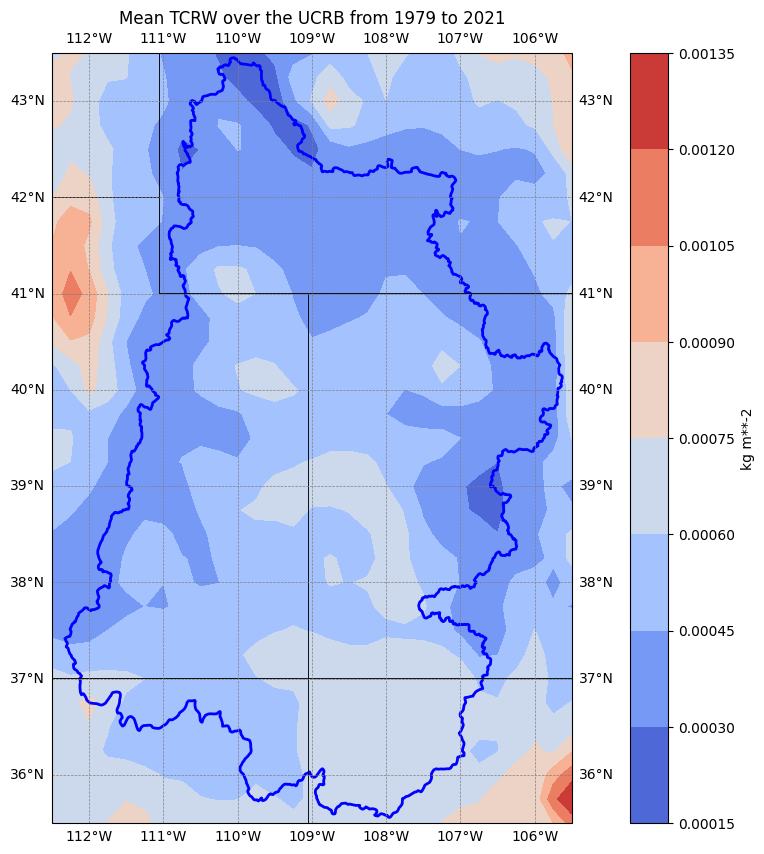

In [15]:
import matplotlib.cm as cmap 

# establish lat and lon values for future use
lat = raw_ds_5['lat']
lon = raw_ds_5['lon']

# Create meshgrid
X, Y = np.meshgrid(lon, lat)

# Create figure and projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot everything! 
p1 = ax.contourf(X, Y, tcrw_avg_ds, cmap='coolwarm', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# Plot the UCRB boundary line
upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())

# Add titles, labels, ect
plt.title("Mean TCRW over the UCRB from 1979 to 2021")
plt.colorbar(p1, label="kg m**-2")
plt.show()



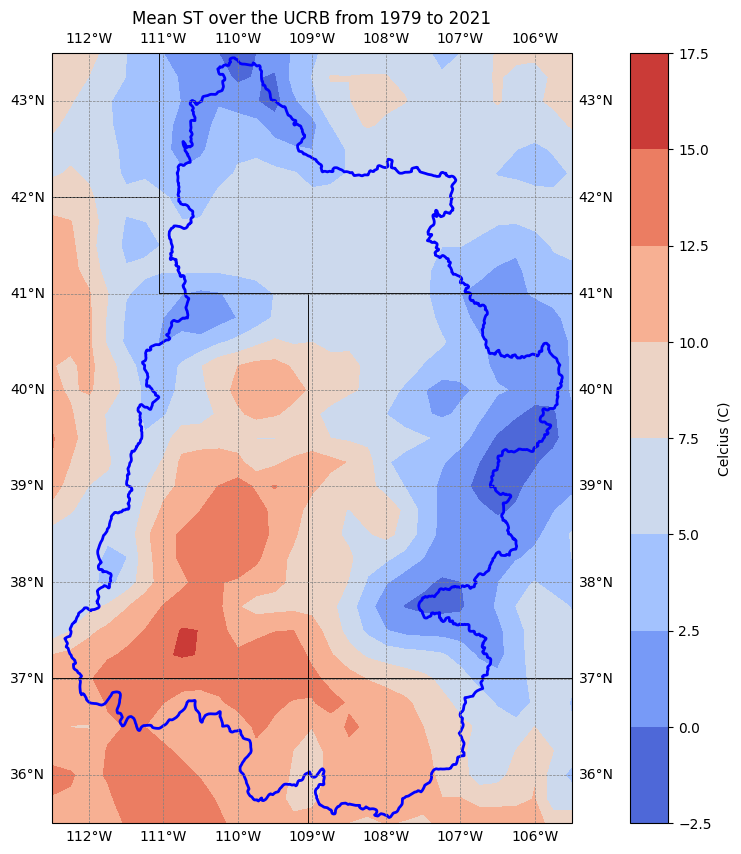

In [16]:
# Create figure and projection
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot everything! 
p1 = ax.contourf(X, Y, st_avg_ds_c, cmap='coolwarm', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# Plot the UCRB boundary line
upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())

# Add titles, labels, ect
plt.title("Mean ST over the UCRB from 1979 to 2021")
plt.colorbar(p1, label="Celcius (C)")
plt.show()


### Now its time to do inital line plotting

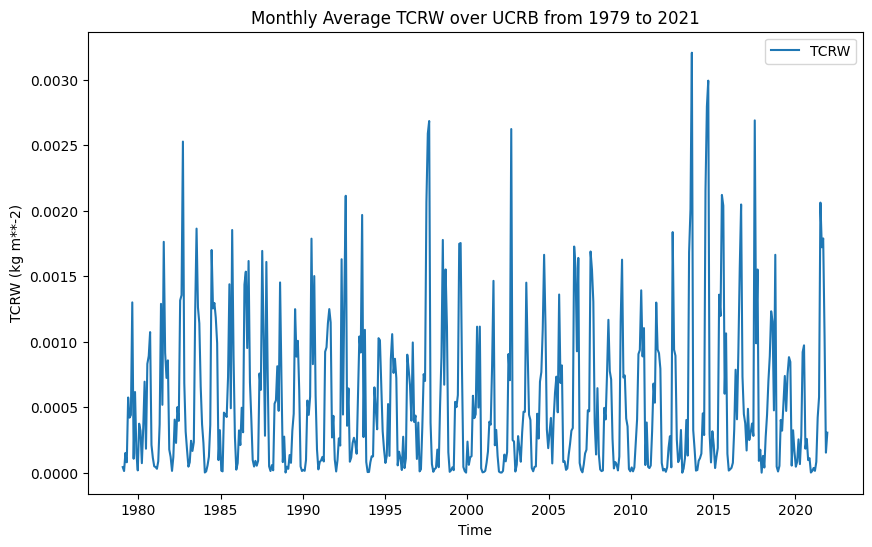

In [17]:
tcrw_lp = raw_ds_5['Total_column_rain_water_surface_Mixed_intervals_Average'].mean(dim=('lat', 'lon'))
time_values = raw_ds_5['Total_column_rain_water_surface_Mixed_intervals_Average'].coords['time'].values

plt.figure(figsize=(10,6))
plt.plot(time_values, tcrw_lp, label='TCRW')
plt.xlabel('Time')
plt.ylabel('TCRW (kg m**-2)')
plt.title('Monthly Average TCRW over UCRB from 1979 to 2021')
plt.legend()
plt.show()


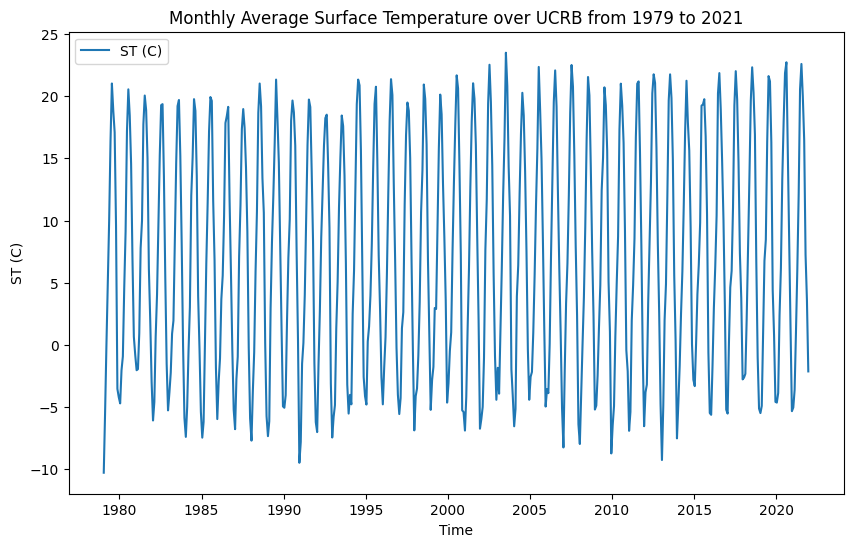

In [18]:
st_lp = raw_ds_5['2_metre_temperature_surface_Mixed_intervals_Average'].mean(dim=('lat', 'lon'))
st_lp_c = st_lp - 273.15
#time_values = raw_ds_5['Total_column_rain_water_surface_Mixed_intervals_Average'].coords['time'].values

plt.figure(figsize=(10,6))
plt.plot(time_values, st_lp_c, label='ST (C)')
plt.xlabel('Time')
plt.ylabel('ST (C)')
plt.title('Monthly Average Surface Temperature over UCRB from 1979 to 2021')
plt.legend()
plt.show()

## Next is basic decomposition of our time series for both variables!
##### Decomposing is used to analyse the time series. It identifies each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways.

Total Column Rain Water

In [19]:
# Convert dataarray to dataframe for easier analysis
tcrw_lp_df = tcrw_lp.to_dataframe(name='value')
tcrw_lp_df

,reftime,value
time,,
1979-01-16 12:00:00,1979-01-01,0.000043
1979-02-15 00:00:00,1979-02-01,0.000013
1979-03-16 12:00:00,1979-03-01,0.000152
1979-04-16 00:00:00,1979-04-01,0.000080
1979-05-16 12:00:00,1979-05-01,0.000575
...,...,...
2021-08-16 12:00:00,2021-08-01,0.001721
2021-09-16 00:00:00,2021-09-01,0.001789
2021-10-16 12:00:00,2021-10-01,0.001045


In [20]:
tcrw_lp_df = tcrw_lp_df.set_index('reftime')

<Figure size 4000x1600 with 0 Axes>

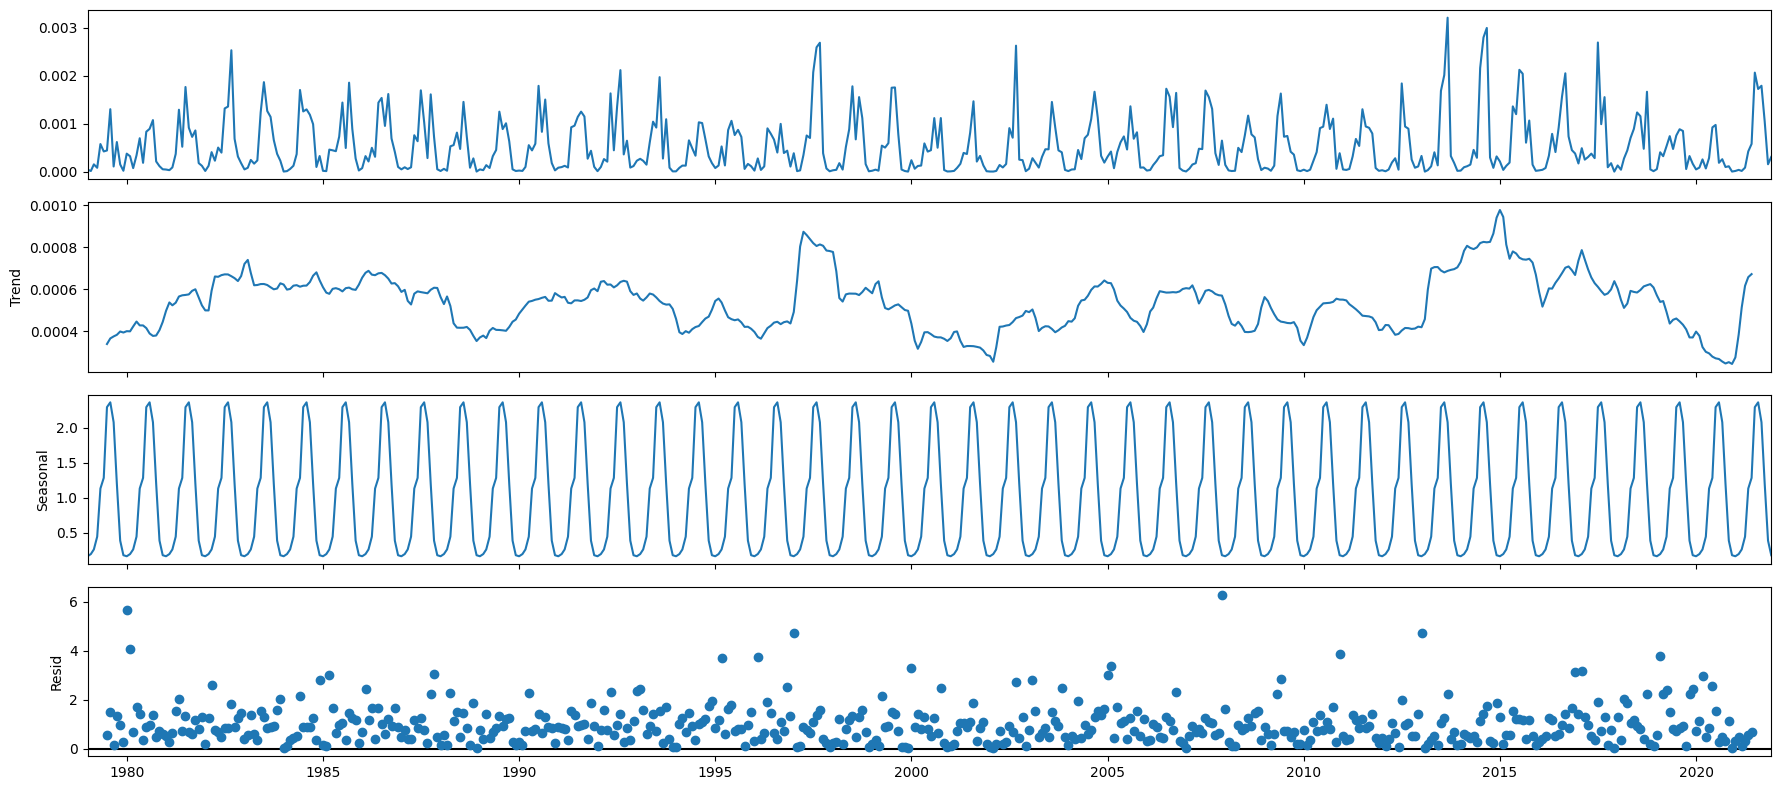

In [21]:
# Perform seasonal decomposition with monthly frequency
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
result = seasonal_decompose(tcrw_lp_df, model='multiplicative', period=12)  # Assuming monthly data
result.plot()
plt.show()

#### Seasonal is stable, that is to be expected. There is something possibly positive with the trend.

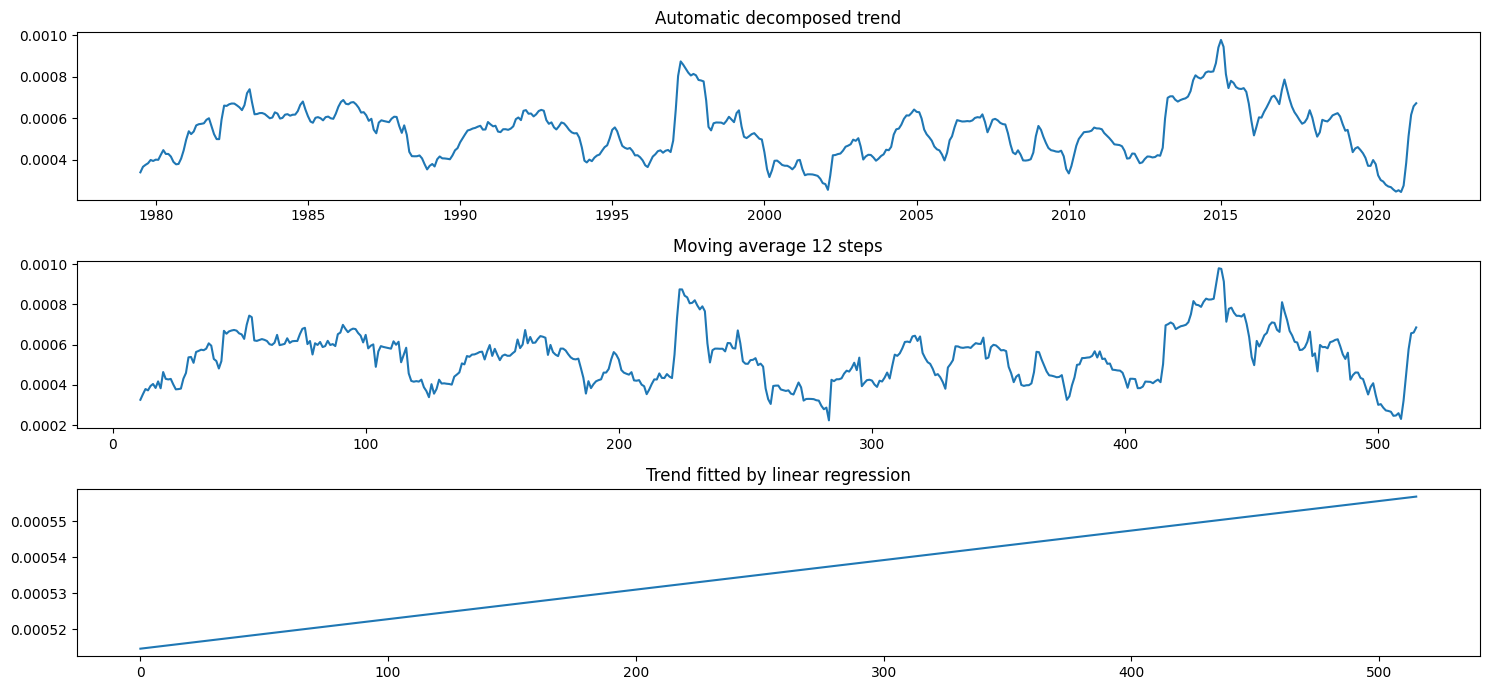

In [22]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = tcrw_lp.rolling(time=12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(tcrw_lp))]
X = np.reshape(X, (len(X), 1))
y = tcrw_lp.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

#### There is a slight positive trend that is revealed with the linear regression. 

Surface Temperature

In [23]:
st_lp_c_df = st_lp_c.to_dataframe(name='value')
st_lp_c_df

,reftime,value
time,,
1979-01-16 12:00:00,1979-01-01,-10.280884
1979-02-15 00:00:00,1979-02-01,-5.470825
1979-03-16 12:00:00,1979-03-01,-0.103912
1979-04-16 00:00:00,1979-04-01,4.857666
1979-05-16 12:00:00,1979-05-01,9.970367
...,...,...
2021-08-16 12:00:00,2021-08-01,19.969452
2021-09-16 00:00:00,2021-09-01,16.470184
2021-10-16 12:00:00,2021-10-01,7.249298


In [24]:
st_lp_c_df = st_lp_c_df.set_index('reftime')

<Figure size 4000x1600 with 0 Axes>

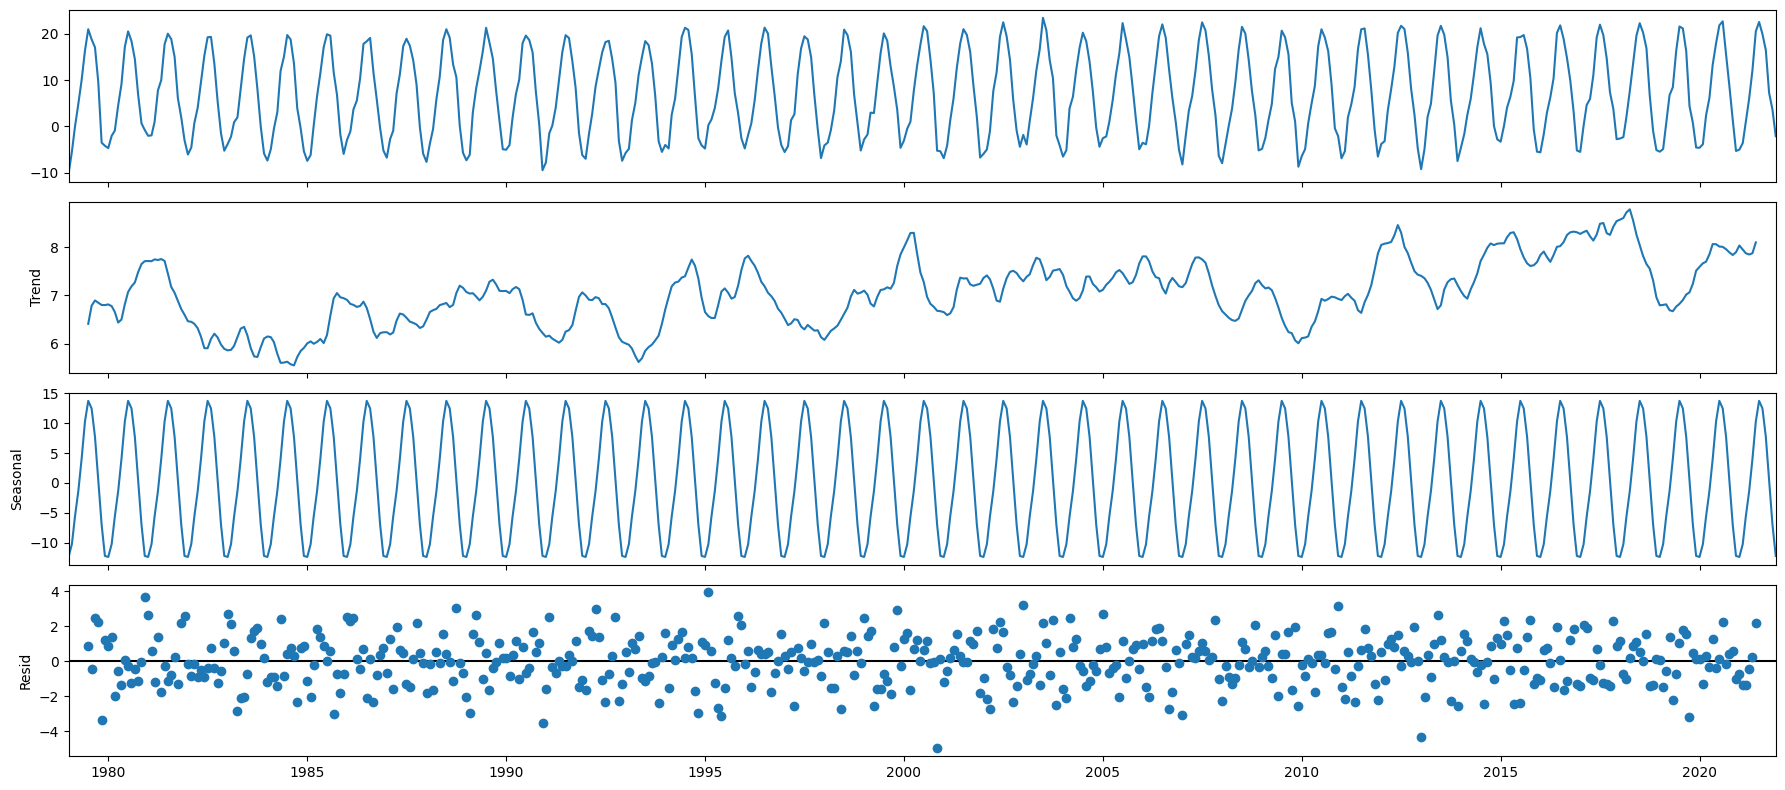

In [25]:
# Perform seasonal decomposition with monthly frequency
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
result2 = seasonal_decompose(st_lp_c_df, model='additive', period=12)  
result2.plot()
plt.show()

#### The trend can be seen! It is seeming to be positive.

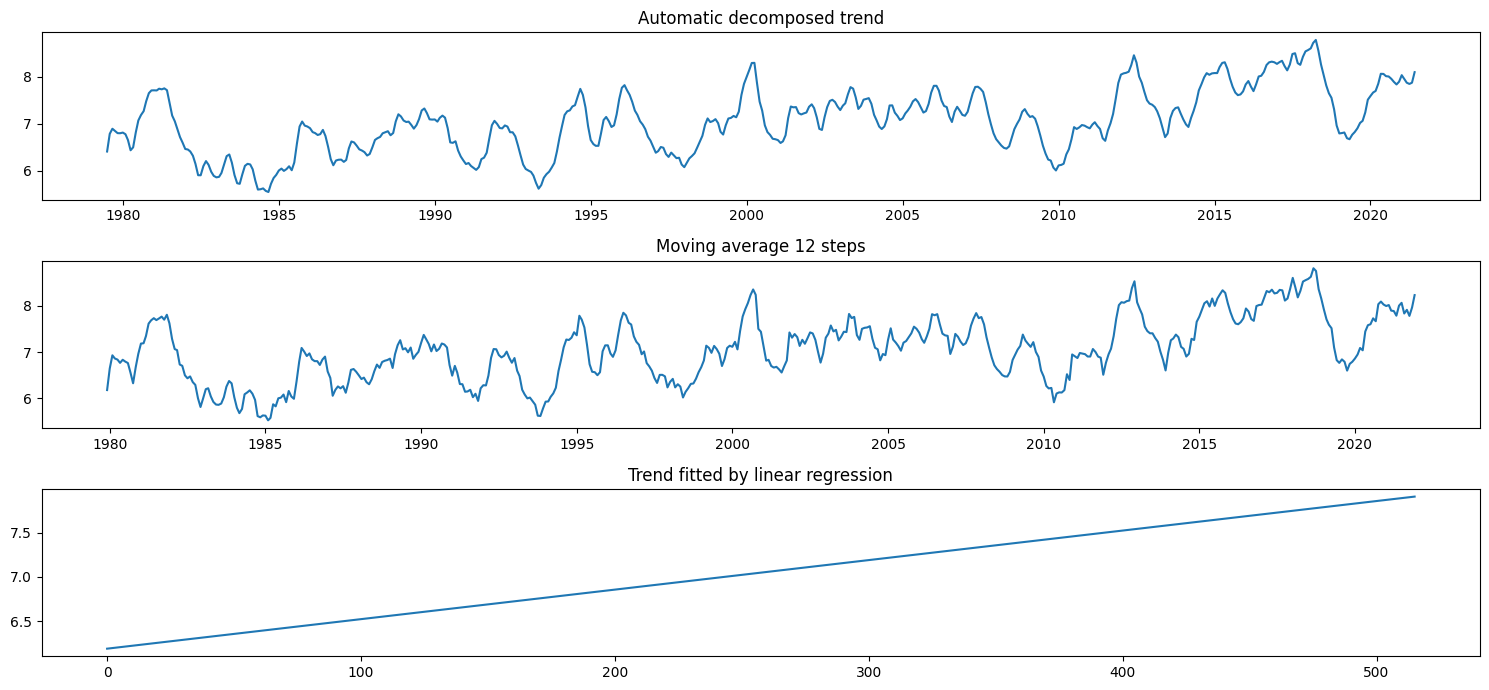

In [26]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax2 = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax2 = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax2 = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax2.plot(result2.trend)
pm_ax2.set_title("Automatic decomposed trend")

mm2 = st_lp_c_df.rolling(12).mean()
mv_ax2.plot(mm2)
mv_ax2.set_title("Moving average 12 steps")


X2 = [i for i in range(0, len(st_lp_c_df))]
X2 = np.reshape(X2, (len(X2), 1))
y2 = st_lp_c_df.values
model2 = LinearRegression()
model2.fit(X2, y2)
# calculate trend
trend2 = model2.predict(X2)
fit_ax2.plot(trend2)
fit_ax2.set_title("Trend fitted by linear regression")

plt.tight_layout()

#### Over time, the temperature has raised by 1 C! 

## EOF Analysis! 

In [27]:
from eofs.xarray import Eof

Total Column Rain Water

In [28]:
# use different variables for this one
tcrw = raw_ds_5['Total_column_rain_water_surface_Mixed_intervals_Average']
tcrw

<xarray.DataArray 'Total_column_rain_water_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 33,
                                                                             lon: 29)>
array([[[2.288818e-05, 2.288818e-05, ..., 0.000000e+00, 0.000000e+00],
        [9.155273e-05, 3.051758e-05, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [1.449585e-04, 1.754761e-04, ..., 4.577637e-05, 1.525879e-05],
        [7.629395e-05, 7.629395e-05, ..., 6.866455e-05, 4.577637e-05]],

       [[1.525879e-04, 1.678467e-04, ..., 1.525879e-05, 0.000000e+00],
        [2.899170e-04, 1.220703e-04, ..., 3.051758e-05, 3.051758e-05],
        ...,
        [3.051758e-05, 3.051758e-05, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 1.525879e-05, 1.525879e-05]],

       ...,

       [[5.111694e-04, 6.027222e-04, ..., 1.144409e-04, 1.525879e-04],
        [7.324219e-04, 6.866455e-04, ..., 8.392334e-05, 9.918213e-05],
        ...,
        [9.918213e-05, 1.220703e-04, ..., 8.392334e-05, 5.340576e-05],
        [1.373291e-04, 1.602173e-04, ..., 1.373291e-04, 1.220703e-04]],

       [[3.051758e-05, 3.051758e-05, ..., 0.000000e+00, 0.000000e+00],
        [4.577637e-05, 1.525879e-05, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [1.510620e-03, 1.449585e-03, ..., 1.831055e-04, 1.373291e-04],
        [1.403809e-03, 1.205444e-03, ..., 2.899170e-04, 2.593994e-04]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 43.5 43.25 43.0 42.75 42.5 ... 36.25 36.0 35.75 35.5
  * lon      (lon) float32 247.5 247.8 248.0 248.2 ... 253.8 254.0 254.2 254.5
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...
Attributes: (12/15)
    long_name:                       Total column rain water (Mixed_intervals...
    units:                           kg m**-2
    description:                     Density
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-228-89_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 89
    Grib1_Parameter_Name:            tcrw
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [29]:
stmp = raw_ds_5['2_metre_temperature_surface_Mixed_intervals_Average']
stmp

<xarray.DataArray '2_metre_temperature_surface_Mixed_intervals_Average' (
                                                                         time: 516,
                                                                         lat: 33,
                                                                         lon: 29)>
array([[[260.56677, 261.1117 , ..., 259.25232, 259.4496 ],
        [261.96716, 261.35193, ..., 259.68005, 259.95935],
        ...,
        [270.63123, 270.6156 , ..., 265.50232, 266.00818],
        [270.53552, 270.3871 , ..., 267.31677, 267.59802]],

       [[268.18634, 269.13165, ..., 268.15118, 268.42853],
        [269.73907, 269.40314, ..., 268.30548, 268.81915],
        ...,
        [271.7547 , 272.17267, ..., 268.95   , 269.60626],
        [271.81525, 272.2469 , ..., 270.89532, 271.60626]],

       ...,

       [[276.7663 , 276.97137, ..., 277.75653, 278.26044],
        [277.53192, 276.8542 , ..., 277.6452 , 278.0495 ],
        ...,
        [282.24677, 281.99677, ..., 277.0495 , 277.35614],
        [282.18622, 281.92645, ..., 279.65497, 279.8288 ]],

       [[271.91858, 272.1588 , ..., 271.97913, 272.46155],
        [272.9889 , 271.81506, ..., 272.0631 , 272.3463 ],
        ...,
        [276.81702, 276.54553, ..., 271.97717, 272.9557 ],
        [276.75647, 276.3131 , ..., 275.38147, 276.06506]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 43.5 43.25 43.0 42.75 42.5 ... 36.25 36.0 35.75 35.5
  * lon      (lon) float32 247.5 247.8 248.0 248.2 ... 253.8 254.0 254.2 254.5
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...
Attributes: (12/14)
    long_name:                       2 metre temperature (Mixed_intervals Ave...
    units:                           K
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-167_L1_Imixed_S123
    Grib1_Center:                    98
    ...                              ...
    Grib1_Parameter:                 167
    Grib1_Parameter_Name:            2t
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [30]:
# remove anomalies from dataset for EOF analysis
ano_free_tcrw = tcrw - tcrw.mean(dim='time')
ano_free_tcrw

<xarray.DataArray 'Total_column_rain_water_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 33,
                                                                             lon: 29)>
array([[[-6.9958298e-04, -7.3524594e-04, -7.2444504e-04, ...,
         -8.0206967e-04, -8.5040397e-04, -9.3624945e-04],
        [-7.0750806e-04, -7.1603199e-04, -7.1282347e-04, ...,
         -6.9111818e-04, -7.7306764e-04, -8.8143902e-04],
        [-7.1442773e-04, -7.1178109e-04, -6.4503867e-04, ...,
         -6.7126105e-04, -7.5394980e-04, -8.5140939e-04],
        ...,
        [-4.8698013e-04, -4.9455778e-04, -5.5446918e-04, ...,
         -6.6081499e-04, -9.4304339e-04, -1.1447788e-03],
        [-5.3357705e-04, -5.0526997e-04, -5.8428448e-04, ...,
         -6.9098512e-04, -1.1109419e-03, -1.3242840e-03],
        [-5.5426959e-04, -5.4421538e-04, -6.2294153e-04, ...,
         -6.5478985e-04, -8.2872820e-04, -1.0689654e-03]],

       [[-5.6988327e-04, -5.9028744e-04, -6.2526291e-04, ...,
         -7.8681088e-04, -8.3514518e-04, -9.3624945e-04],
        [-5.0914381e-04, -6.2447926e-04, -6.5941771e-04, ...,
         -6.6060061e-04, -7.4255007e-04, -8.5092144e-04],
        [-5.4658105e-04, -6.5837533e-04, -6.1452109e-04, ...,
         -6.1022589e-04, -6.9291465e-04, -8.0563303e-04],
...
        [-6.9297379e-04, -6.6240446e-04, -5.4683979e-04, ...,
         -5.5400346e-04, -9.2015520e-04, -1.1371494e-03],
        [-5.7935342e-04, -5.5867573e-04, -4.9273175e-04, ...,
         -5.6891481e-04, -1.0727949e-03, -1.2861370e-03],
        [-4.9323443e-04, -4.6029204e-04, -4.7798303e-04, ...,
         -5.4034893e-04, -7.6006365e-04, -9.9267147e-04]],

       [[-6.9195358e-04, -7.2761654e-04, -7.1681564e-04, ...,
         -8.0206967e-04, -8.5040397e-04, -9.3624945e-04],
        [-7.5328443e-04, -7.3129078e-04, -7.2045287e-04, ...,
         -6.9111818e-04, -7.7306764e-04, -8.8143902e-04],
        [-7.9072168e-04, -7.4992806e-04, -6.4503867e-04, ...,
         -6.7126105e-04, -7.5394980e-04, -8.5140939e-04],
        ...,
        [ 1.2296336e-03,  1.3517557e-03,  7.5778668e-04, ...,
         -1.1149858e-04, -7.6756731e-04, -1.1142612e-03],
        [ 8.3208457e-04,  7.6883892e-04,  3.0072528e-04, ...,
         -2.5610963e-04, -9.7361277e-04, -1.2022137e-03],
        [ 7.7324506e-04,  5.8493501e-04,  3.3186399e-05, ...,
         -2.8094952e-04, -6.0747575e-04, -8.5534237e-04]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 43.5 43.25 43.0 42.75 42.5 ... 36.25 36.0 35.75 35.5
  * lon      (lon) float32 247.5 247.8 248.0 248.2 ... 253.8 254.0 254.2 254.5
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...

In [31]:
ano_free_stmp = stmp - stmp.mean(dim='time')

In [32]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs. (source: M04N05)
coslat = np.cos(np.deg2rad(ano_free_tcrw.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ano_free_tcrw, weights=wgts)


In [33]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input variable at each grid point, and the
# leading PC time series itself. (Source: M04N05)
eofs = solver.eofsAsCorrelation(neofs=5)
pcs = solver.pcs(npcs=5, pcscaling=1)

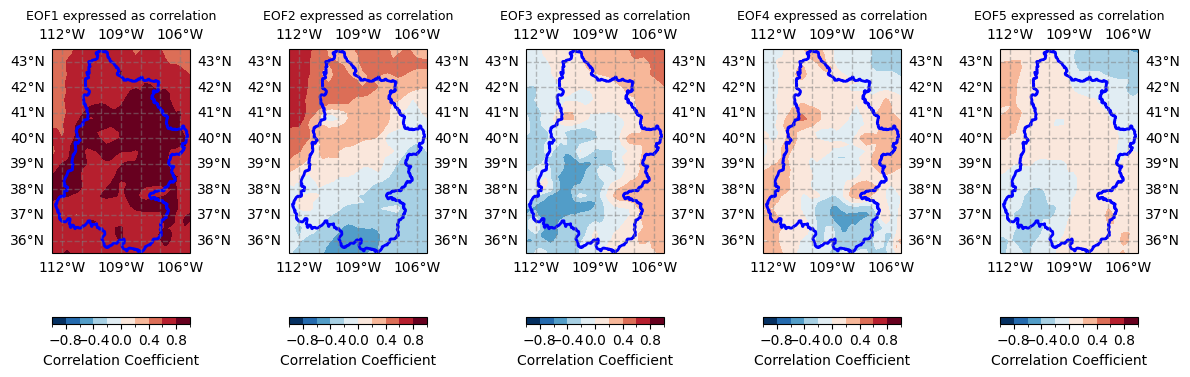

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

# Plotting the map
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 13), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOFs
for i in range(5):
    clevs = np.linspace(-1, 1, 11)
    ax = axes[i]
    fill = eofs[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
    
    # Calculate variance fraction
    ax.set_title(f'EOF{i+1} expressed as correlation', fontsize=9)
    
    # add colorbar
    cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Correlation Coefficient', fontsize=10)

#plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()
plt.show()


#### There is very high correlation for the first EOF!! This could be the dominant climate pattern.
#### We are in a way seeing the long term trend! TCRW could be increasing over time, slightly, but does that mean that it is raining more and snowing less due to a temperature increase? Does it indicate atmospheric instability? Data like this will in the future allow and enable me to further investigate these trends.

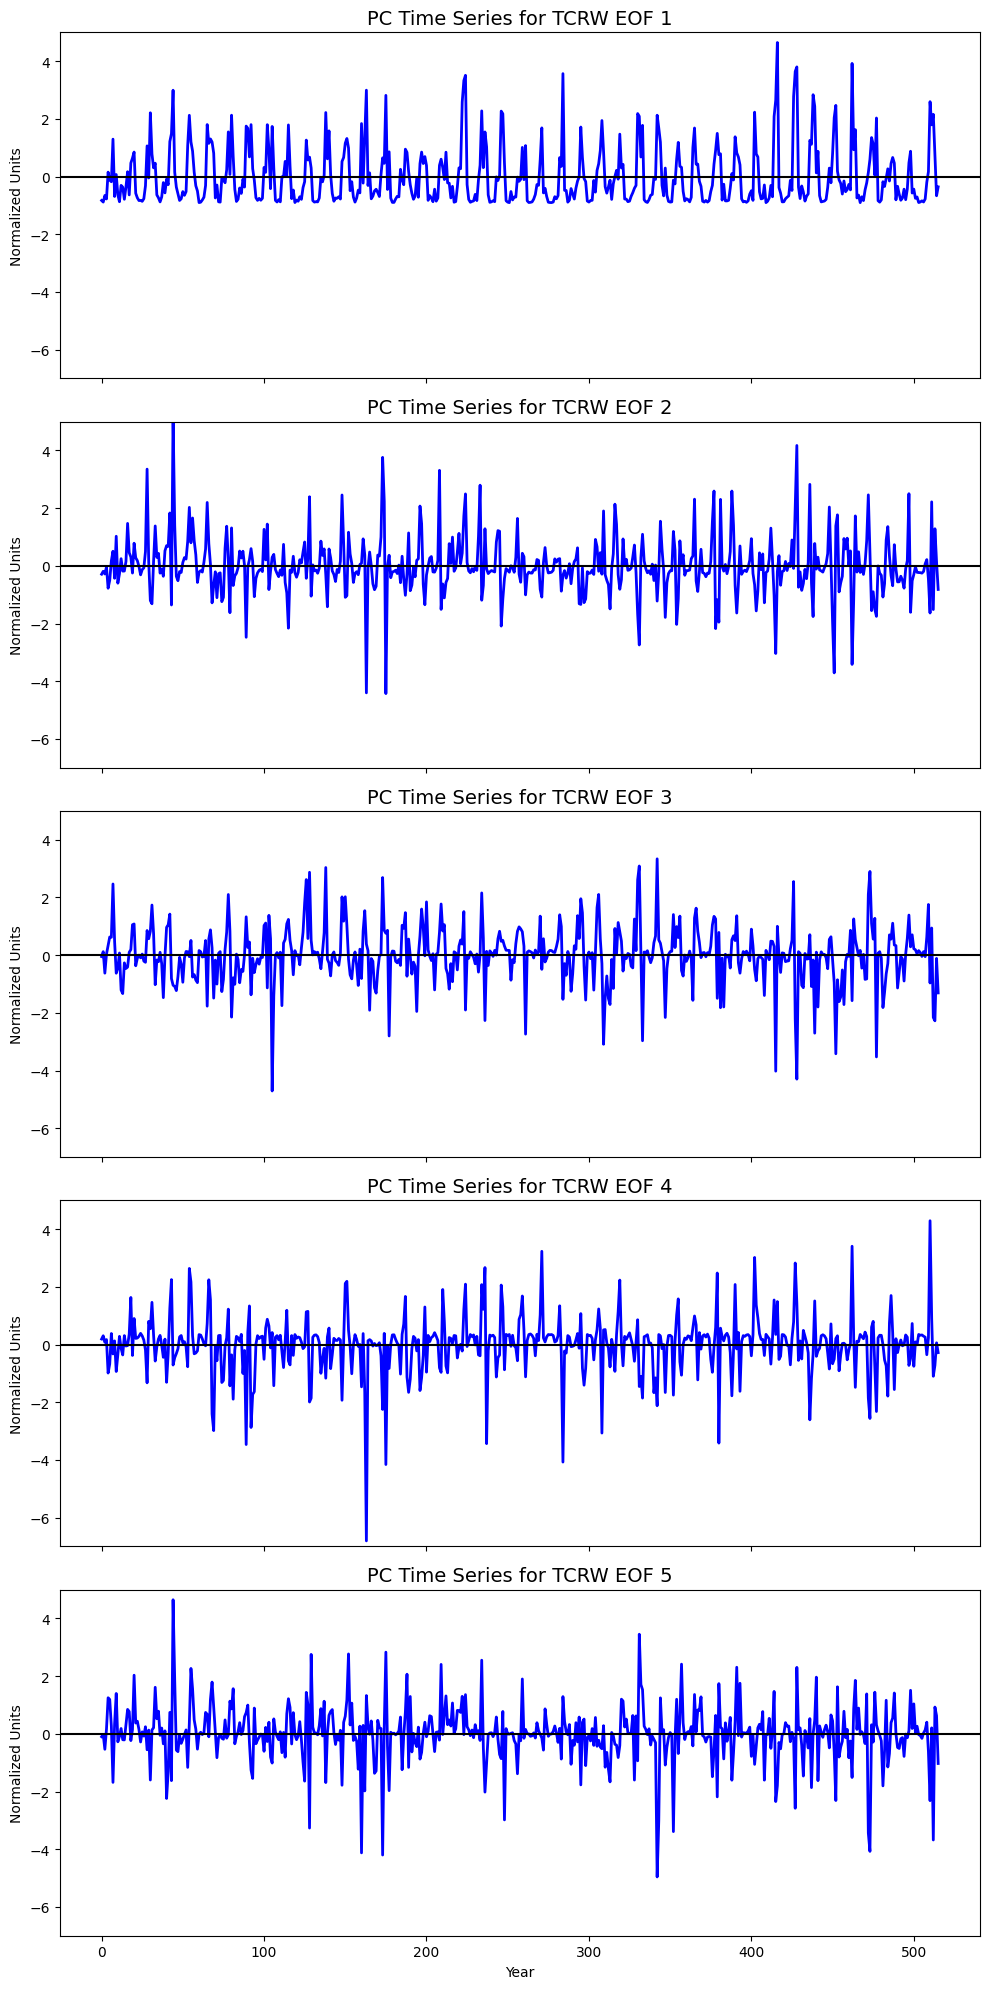

In [51]:
# Plot the PC time series for the first 5 EOFs in individual subplots.
fig, axes = plt.subplots(5, 1, figsize=(10, 20), sharex=True)  

for i, ax in enumerate(axes, 1):  # Loop over subplots
    ax.plot(pcs[:, i-1], color='b', linewidth=2)  
    ax.axhline(0, color='k')  # Add a horizontal line at y=0
    ax.set_ylim(-7, 5)  
    ax.set_ylabel('Normalized Units')  
    ax.set_title(f'PC Time Series for TCRW EOF {i}', fontsize=14)  

axes[-1].set_xlabel('Year')
plt.tight_layout()  
plt.show()  

# Note and reminder:
# A PC graph indicate that the values have been standardized to facilitate meaningful comparisons and analyses of the principal component time series.

#### The first PC graph has the most stable and consistent pattern, you can see the slight increase on TCRW over time. You can see the trend decaying with each PC in the comparison.

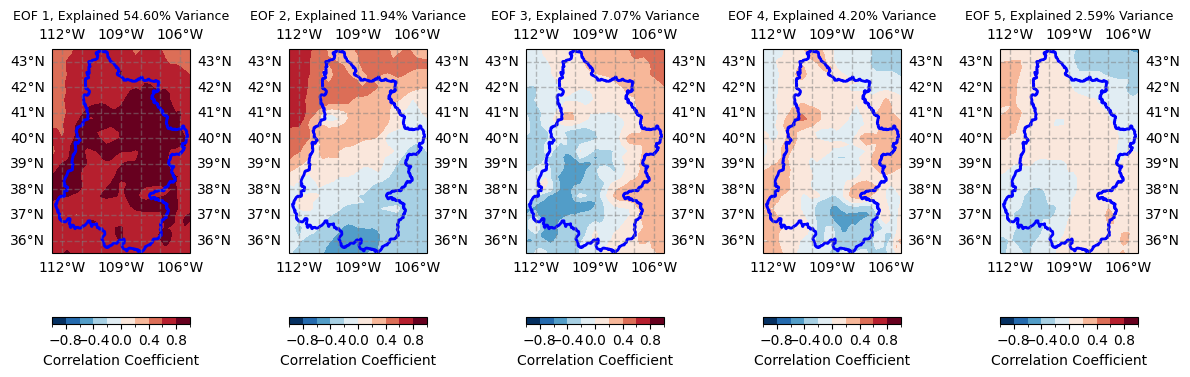

In [36]:
# Now to plot the variance fraction to see exactly how high each percentage for the EOFs are
var_frac = solver.varianceFraction()

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

# Plotting the map
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 13), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOFs
for i in range(5):
    clevs = np.linspace(-1, 1, 11)
    ax = axes[i]
    fill = eofs[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
    
    # Calculate variance fraction
    ax.set_title(f'EOF {i+1}, Explained {var_frac[i].values*100:.2f}% Variance', fontsize=9)
    
    # add colorbar
    cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Correlation Coefficient', fontsize=10)

#plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()
plt.show()


#### 54% is very high, even for a variance fraction. That means this EOF really does hold some weight in the trends and results from our previous visualizations. Decreased rainfall and overall moisture in a climate region can be an indication of possible aridification but this might be something more than what data analysis can provide. There is other modeling and research studies being done on the aridification of the CRB, but this data for TCRW has given us substantial insight. 

(2.299470517459995e-16, 0.5560084676742554)

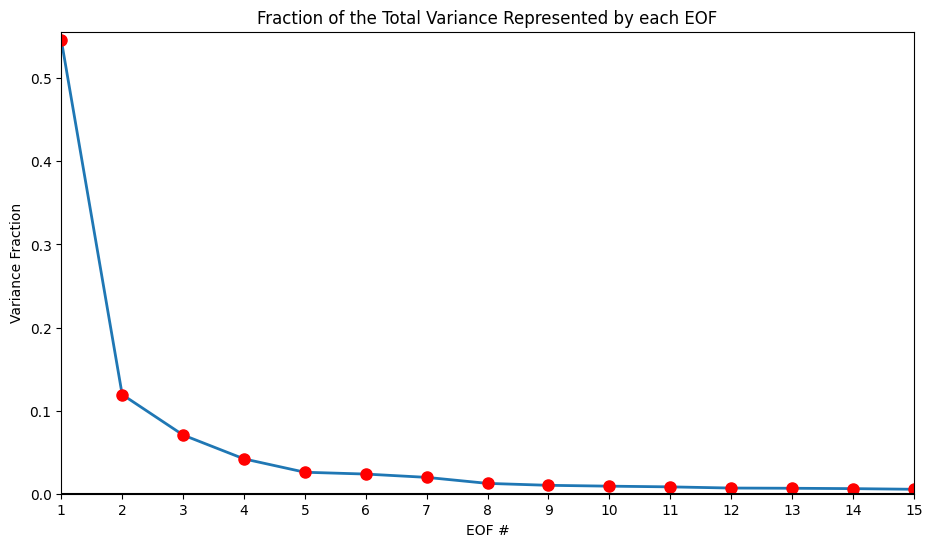

In [46]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, var_frac[0:15], linewidth=2)
plt.plot(eof_num, var_frac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the Total Variance Represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(var_frac), np.max(var_frac)+0.01)

Surface Temperature

In [47]:
ano_free_stmp

<xarray.DataArray '2_metre_temperature_surface_Mixed_intervals_Average' (
                                                                         time: 516,
                                                                         lat: 33,
                                                                         lon: 29)>
array([[[-21.622864  , -20.805817  , -19.783722  , ..., -22.079346  ,
         -21.491943  , -21.789642  ],
        [-20.68164   , -20.021118  , -18.99585   , ..., -21.40738   ,
         -21.08252   , -21.21875   ],
        [-19.487183  , -18.853882  , -18.294342  , ..., -21.017609  ,
         -20.673218  , -20.841003  ],
        ...,
        [-15.465729  , -15.425598  , -15.384949  , ..., -15.072571  ,
         -13.549774  , -12.787903  ],
        [-14.899017  , -14.75415   , -14.559296  , ..., -15.773926  ,
         -13.632507  , -13.23172   ],
        [-14.637878  , -14.4444275 , -13.961121  , ..., -16.088745  ,
         -14.88443   , -14.533997  ]],

       [[-14.003296  , -12.785858  , -11.597748  , ..., -13.049622  ,
         -12.593079  , -12.810699  ],
        [-12.909729  , -11.96991   , -10.7786255 , ..., -12.975311  ,
         -12.457092  , -12.358948  ],
        [-11.72113   , -10.902283  , -10.561493  , ..., -12.694916  ,
         -12.106384  , -12.010498  ],
...
        [ -3.4615173 ,  -3.489746  ,  -3.3944092 , ...,  -3.0585938 ,
          -1.9361877 ,  -1.5239258 ],
        [ -3.2834778 ,  -3.3729858 ,  -2.9535217 , ...,  -3.140808  ,
          -2.0853271 ,  -1.8837585 ],
        [ -2.9871826 ,  -2.9050598 ,  -2.6619873 , ...,  -3.6470337 ,
          -2.5462341 ,  -2.3032227 ]],

       [[-10.271057  ,  -9.7586975 ,  -9.381134  , ...,  -8.916992  ,
          -8.765137  ,  -8.777679  ],
        [ -9.659912  ,  -9.557983  ,  -9.177246  , ...,  -8.877838  ,
          -8.699463  ,  -8.831787  ],
        [ -9.326782  ,  -9.213013  ,  -9.059723  , ...,  -8.597443  ,
          -8.411255  ,  -8.586853  ],
        ...,
        [ -9.121735  ,  -9.177307  ,  -9.130798  , ...,  -7.4453735 ,
          -6.89328   ,  -6.232971  ],
        [ -8.713226  ,  -8.824219  ,  -8.572723  , ...,  -7.511963  ,
          -7.157654  ,  -6.28421   ],
        [ -8.416931  ,  -8.518402  ,  -8.521423  , ...,  -8.010376  ,
          -6.8197327 ,  -6.0669556 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 43.5 43.25 43.0 42.75 42.5 ... 36.25 36.0 35.75 35.5
  * lon      (lon) float32 247.5 247.8 248.0 248.2 ... 253.8 254.0 254.2 254.5
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...

In [48]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs. (source: M04N05)
coslat2 = np.cos(np.deg2rad(ano_free_stmp.coords['lat'].values))
wgts2 = np.sqrt(coslat)[..., np.newaxis]
solver2 = Eof(ano_free_stmp, weights=wgts)


In [56]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input variable at each grid point, and the
# leading PC time series itself. (Source: M04N05)
eofs2 = solver2.eofsAsCorrelation(neofs=5)
pcs2 = solver2.pcs(npcs=5, pcscaling=1)

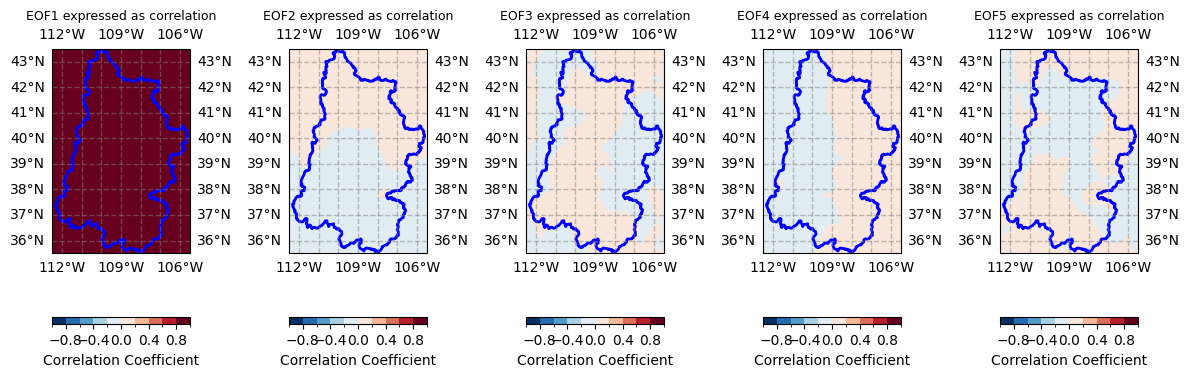

In [57]:
# Plotting the map
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 13), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOFs
for i2 in range(5):
    clevs = np.linspace(-1, 1, 11)
    ax = axes[i2]
    fill = eofs2[i2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
    
    # Calculate variance fraction
    ax.set_title(f'EOF{i2+1} expressed as correlation', fontsize=9)
    
    # add colorbar
    cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Correlation Coefficient', fontsize=10)

#plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()
plt.show()

#### There is an extremely high correlation for the first EOF! This could be the dominant climate pattern.
#### We are in a way seeing the long term trend! ST could possibly be increasing over time, and the first EOF seems to have the highest correlation, whereas the other EOFs display a dramatic decrease. This opens up the possibility of further research and avenues of temperature study for the UCRB. Data like this will in the future allow and enable me to further investigate these trends.

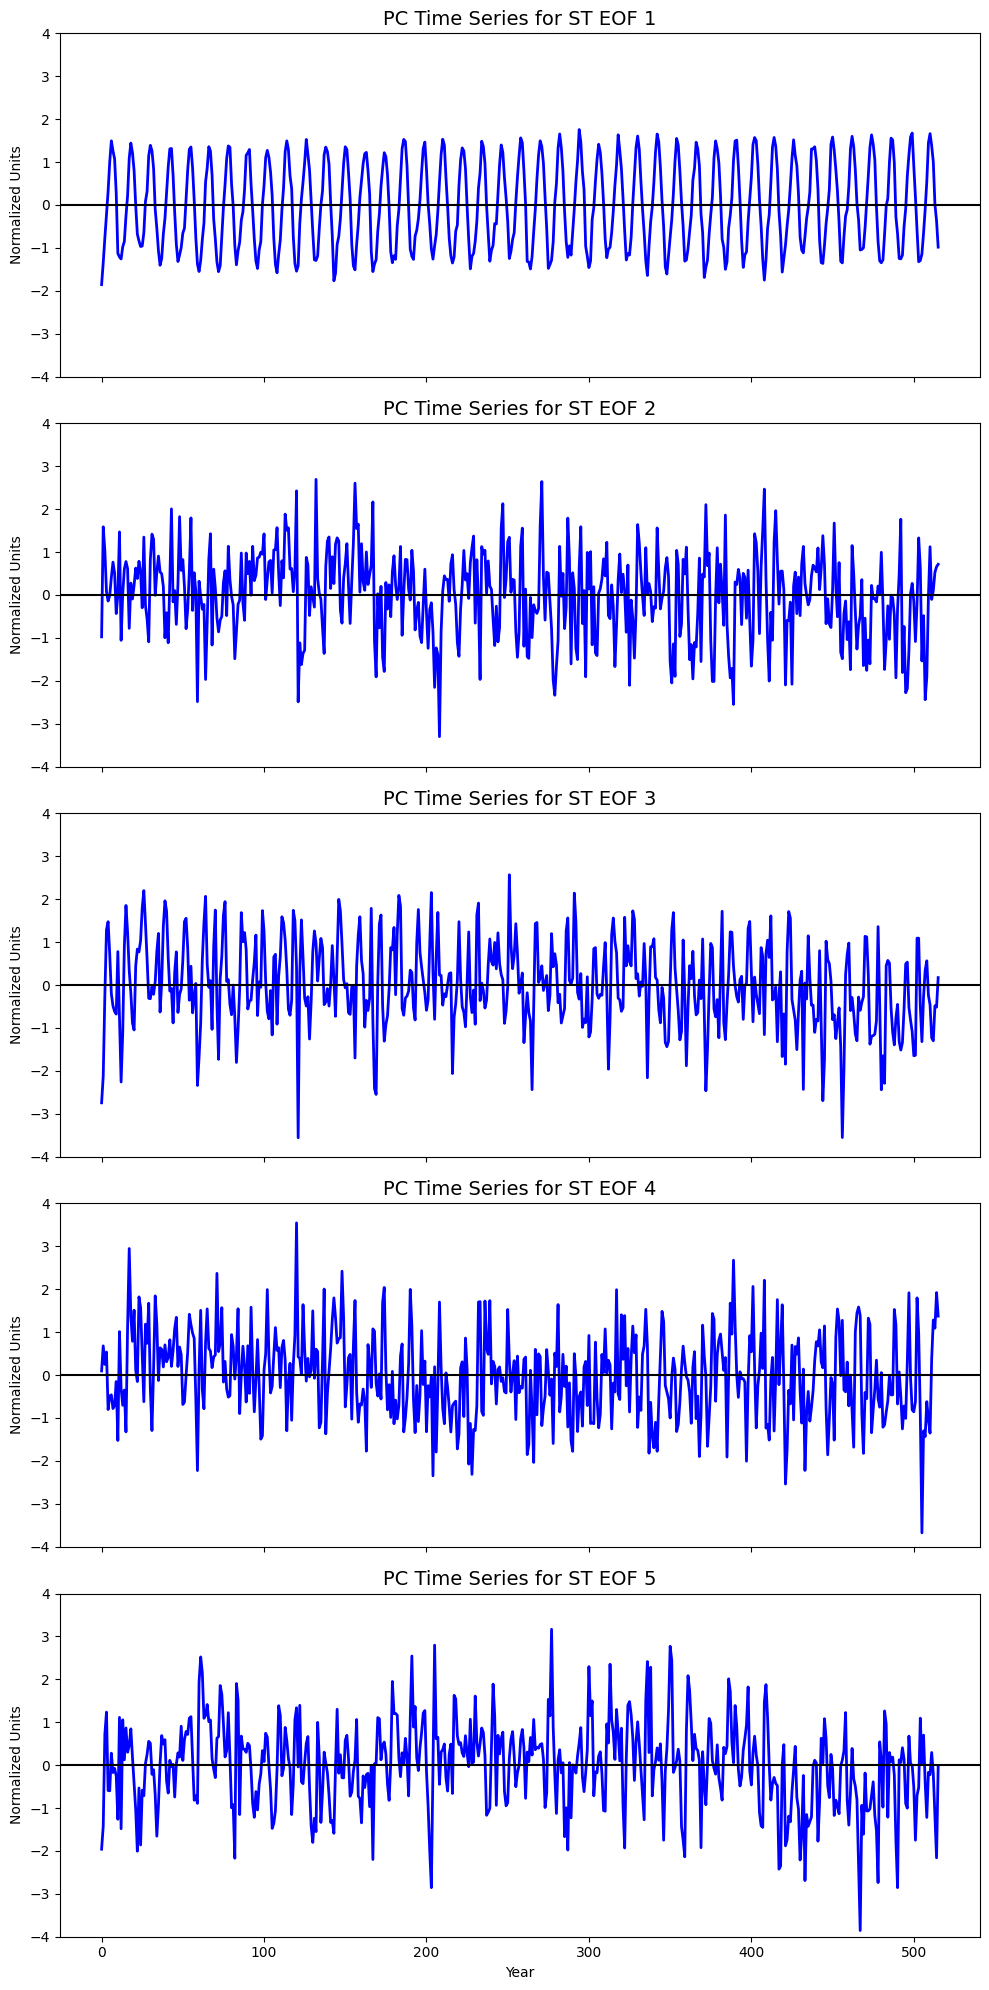

In [53]:
# Plot the PC time series for the first 5 EOFs in individual subplots.
fig, axes = plt.subplots(5, 1, figsize=(10, 20), sharex=True)  

for i, ax in enumerate(axes, 1):  # Loop over subplots
    ax.plot(pcs2[:, i-1], color='b', linewidth=2)  
    ax.axhline(0, color='k')  # Add a horizontal line at y=0
    ax.set_ylim(-4, 4)  
    ax.set_ylabel('Normalized Units')  
    ax.set_title(f'PC Time Series for ST EOF {i}', fontsize=14)  

axes[-1].set_xlabel('Year')
plt.tight_layout()  
plt.show()  

# Note and reminder:
# A PC graph indicate that the values have been standardized to facilitate meaningful comparisons and analyses of the principal component time series.

#### The first PC graph has the most stable and consistent pattern, you can see the slight increase on ST over time. You can see the trend decaying with each PC in the comparison. While it is hard to see, the previous linear regression aided in the visualization of this change.

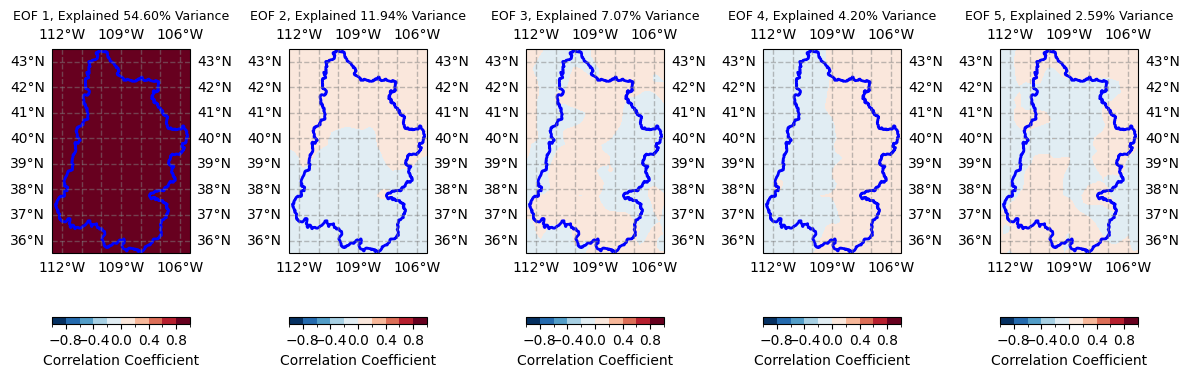

In [58]:
# Now to plot the variance fraction to see exactly how high each percentage for the EOFs are
var_frac2 = solver.varianceFraction()

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

# Plotting the map
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 13), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOFs
for i2 in range(5):
    clevs = np.linspace(-1, 1, 11)
    ax = axes[i2]
    fill = eofs2[i2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
    
    # Calculate variance fraction
    ax.set_title(f'EOF {i2+1}, Explained {var_frac2[i2].values*100:.2f}% Variance', fontsize=9)
    
    # add colorbar
    cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Correlation Coefficient', fontsize=10)

#plt.subplots_adjust(right=0.85, bottom=0.15)
plt.tight_layout()
plt.show()

#### 54% is very high, even for a variance fraction. That means this EOF really does hold some weight in the trends and results from our previous visualizations. Increased surface temperature in a climate region can be an indication of possible aridification but this might be something more than what data analysis can provide. There is other modeling and research studies being done on the aridification of the CRB, but this data for ST has given us substantial insight. However, it is interesting that percentages are the exact same as TCRW. It could mean there is a bias in the data since its from the same dataset, or there was a data anlysis step that caused this to happen. However, the data decomposition graphs helped us initially.

(2.299470517459995e-16, 0.5560084676742554)

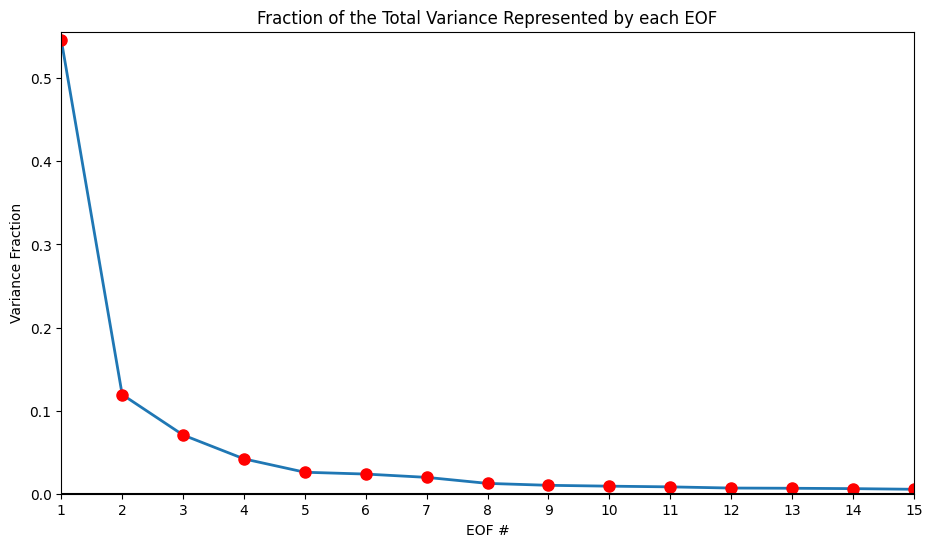

In [59]:
# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num2 = range(1, 16)
plt.plot(eof_num2, var_frac2[0:15], linewidth=2)
plt.plot(eof_num2, var_frac2[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the Total Variance Represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(var_frac2), np.max(var_frac2)+0.01)

## Pearson correlation analysis of both variables together!

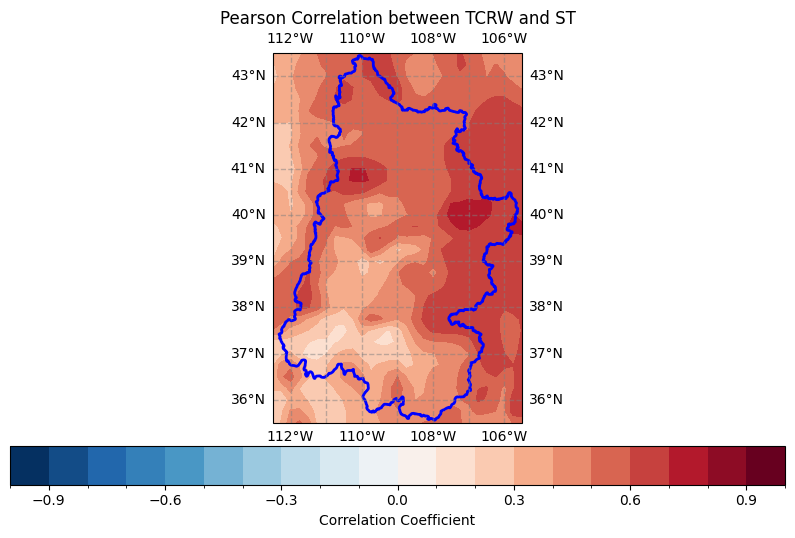

In [62]:
# now to calculate the corr coef for the TCRW and ST
corr_tcrw_st = xr.corr(ano_free_tcrw, ano_free_stmp, dim='time')

# plot the correlation map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# Plot the EOF
clevs = np.linspace(-1, 1, 21)
fill = corr_tcrw_st.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
upper_colorado_gdf.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, transform=ccrs.PlateCarree())
# Calculate variance fraction
ax.set_title('Pearson Correlation between TCRW and ST')

# add colorbar
cbar = plt.colorbar(fill, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Correlation Coefficient', fontsize=10)

#### TCRW and ST seem to be closely related, which is not a surprise.

# Closing thoughts

### The data analysis uncovered climatologically interesting trends and opened up avenues for further analysis. I sought to find any common patterns or trends that point to beginning signs of aridification through seasonal decomposition and EOF analysis. There are many publications and peer-reviewed studies on the aridification of the CRB that indicate somber findings that the CRB is going from a semi-arid to arid environment. I think the patterns and trends found during this analysis also coincide with these research studies. If this were more nuanced and had more variables, multiple analysi approaches, and even different packages involved it could provide better results. However, this is a quaint start.

In [63]:
client.close()